In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from get_data import *

In [67]:
i=0

In [130]:
df_aux = ds[ds['precio']>1400].sort_values(by='precio', ascending=False).reset_index(drop=True)
df_aux = df_aux['descripcion'].values
precio = ds[ds['descripcion']==df_aux[i]]['precio'].values[0]
print(i, precio, df_aux[i])
i+=1

62 1540.0 magnifico piso en mera para alquilar por temporadas cerca de la playa y con todos los servicios que te ofrece la localidad de mera es el precio por quincena disponible el mes de junio primera de julio segunda de agosto y septiembre el piso consta de tres habitaciones dos baños salon y coci


#### Data load

In [3]:
ds, cols_model = get_data_model_v2()
ds_municipios, mun = get_data_municipios()
ds_zonas, zonas = get_data_zonas()

ds['precio_m2'] = ds['precio']/ds['tamano']

Database object created


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


Best k for clustering zones: 4
Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


#### Precios medios por zona

In [24]:
viv_zonas = ds.groupby('zona_v2').agg({'titulo':'count','precio':'mean', 'precio_m2':'mean', 'tamano':'mean', 'n_habitaciones':'mean'}).reset_index()
viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
viv_zonas = viv_zonas.sort_values(['precio_m2', 'n_habitaciones', 'tamano'], ascending=False)
viv_zonas = viv_zonas[viv_zonas['n_viviendas'] >= 5]
plano = viv_zonas[['n_habitaciones', 'tamano']].copy()
display(viv_zonas)
# plt.scatter(plano['n_habitaciones'], plano['tamano'])

,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
13,maianca,11,1607.727273,17.923288,135.454545,3.000000
20,perillo,31,1343.709677,11.832662,116.838710,2.870968
15,monte alto - zalaeta - atocha,74,807.364865,11.532090,74.148649,2.135135
6,ciudad vieja - centro,31,1113.580645,11.221387,102.161290,2.161290
10,ensanche - juan florez,130,1213.830769,10.947123,119.515385,2.807692
11,falperra-santa lucia,14,740.714286,10.334224,76.357143,2.285714
7,cuatro caminos - plaza de la cubela,74,928.040541,9.567359,102.027027,2.810811
21,riazor - los rosales,46,791.847826,9.195199,87.260870,2.586957
12,los castros - castrillon,31,699.193548,9.050082,80.838710,2.483871
23,someso - matogrande,52,850.961538,9.019203,103.653846,2.730769


#### Precios medio por zonas, para viviendas de 2 y 3 habitaciones por separado

In [13]:
min_viviendas_grupo = 5

ds_aux = ds.copy()
ds_aux = ds_aux[ds_aux['n_habitaciones']==2]
viv_zonas = ds_aux.groupby('zona_v2').agg({'titulo':'count','precio':'mean', 'precio_m2':'mean', 'tamano':'mean', 'n_habitaciones':'mean'}).reset_index()
viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
viv_zonas = viv_zonas[viv_zonas['n_viviendas']>=min_viviendas_grupo]
viv_zonas = viv_zonas.sort_values(['precio_m2', 'n_habitaciones', 'tamano'], ascending=False)
precio_m2_2hab = viv_zonas[['zona_v2', 'precio_m2', 'n_viviendas']].copy()

ds_aux = ds.copy()
ds_aux = ds_aux[ds_aux['n_habitaciones']==3]
viv_zonas = ds_aux.groupby('zona_v2').agg({'titulo':'count','precio':'mean', 'precio_m2':'mean', 'tamano':'mean', 'n_habitaciones':'mean'}).reset_index()
viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
viv_zonas = viv_zonas[viv_zonas['n_viviendas']>=min_viviendas_grupo]
viv_zonas = viv_zonas.sort_values(['precio_m2', 'n_habitaciones', 'tamano'], ascending=False)
precio_m2_3hab = viv_zonas[['zona_v2', 'precio_m2', 'n_viviendas']].copy()

mix = pd.merge(precio_m2_2hab, precio_m2_3hab, on='zona_v2', how='outer')
mix['diferencia'] = mix['precio_m2_x'] - mix['precio_m2_y']
mix['avg_precio_m2'] = (mix['precio_m2_x']*mix['n_viviendas_x'] + mix['precio_m2_y']*mix['n_viviendas_y'])/(mix['n_viviendas_x']+mix['n_viviendas_y'])
mix = mix.sort_values(['avg_precio_m2'], ascending=False)
plano = viv_zonas[['n_habitaciones', 'tamano']].copy()
display(mix)

,zona_v2,precio_m2_x,n_viviendas_x,precio_m2_y,n_viviendas_y,diferencia,avg_precio_m2
0,perillo,14.364335,11.0,8.422131,9.0,5.942204,11.690343
2,ciudad vieja - centro,11.389127,16.0,11.957734,7.0,-0.568607,11.562181
4,ensanche - juan florez,10.279300,34.0,10.593942,46.0,-0.314642,10.460219
3,monte alto - zalaeta - atocha,10.584541,28.0,9.221173,21.0,1.363368,10.000240
1,cuatro caminos - plaza de la cubela,11.629424,20.0,8.484084,40.0,3.145340,9.532531
5,riazor - los rosales,9.688662,17.0,8.323716,19.0,1.364946,8.968274
6,os mallos,9.001693,10.0,8.515858,24.0,0.485834,8.658751
9,someso - matogrande,8.918946,13.0,8.242366,20.0,0.676580,8.508898
10,los castros - castrillon,8.757807,13.0,7.977744,12.0,0.780063,8.383377
7,agra del orzan - ventorrillo,8.988700,7.0,8.079136,26.0,0.909564,8.272074


### K-means: Agrupamos las zonas teniendo en cuenta solamente el precio m2

In [25]:
viv_zonas = viv_zonas.reset_index(drop=True)
viv_zonas

,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
0,maianca,11,1607.727273,17.923288,135.454545,3.000000
1,perillo,31,1343.709677,11.832662,116.838710,2.870968
2,monte alto - zalaeta - atocha,74,807.364865,11.532090,74.148649,2.135135
3,ciudad vieja - centro,31,1113.580645,11.221387,102.161290,2.161290
4,ensanche - juan florez,130,1213.830769,10.947123,119.515385,2.807692
5,falperra-santa lucia,14,740.714286,10.334224,76.357143,2.285714
6,cuatro caminos - plaza de la cubela,74,928.040541,9.567359,102.027027,2.810811
7,riazor - los rosales,46,791.847826,9.195199,87.260870,2.586957
8,los castros - castrillon,31,699.193548,9.050082,80.838710,2.483871
9,someso - matogrande,52,850.961538,9.019203,103.653846,2.730769


In [36]:
df, k, viv_zonas = cluster_zonas(ds)

In [40]:
viv_zonas

,zona_v2,n_viviendas,precio_m2,cluster
0,abegondo,1,18.181818,0
1,maianca,11,17.923288,0
2,perillo,31,11.832662,2
3,monte alto - zalaeta - atocha,74,11.532090,2
4,ciudad vieja - centro,31,11.221387,2
5,ensanche - juan florez,130,10.947123,2
6,falperra-santa lucia,14,10.334224,2
7,cuatro caminos - plaza de la cubela,74,9.567359,1
8,riazor - los rosales,46,9.195199,1
9,los castros - castrillon,31,9.050082,1


In [35]:
def closest_zona(precio, df_sorted):
    precios = df_sorted['precio_m2'].values
    for i in range(len(precios)):
        if precios[i]  < precio:
            precio_ant = precios[max(i-1, 0)]
            precio_act = precios[i]
            if abs(precio-precio_ant) < abs(precio-precio_act):
                return df_sorted.loc[max(i-1, 0)]['zona_v2']
    return df_sorted.loc[len(precios)-1]['zona_v2']

def weighted_mean(group):
    n = group['n_viviendas']
    precio_m2 = group['precio_m2']
    aux = (n*precio_m2).sum()/n.sum()
    return(aux)
    

def cluster_zonas(df):
    viv_zonas = df.groupby('zona_v2').agg({'titulo':'count', 'precio_m2':'mean'}).reset_index()
    viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
    viv_zonas = viv_zonas.sort_values(['precio_m2'], ascending=False).reset_index(drop=True)
    viv_zonas_original = viv_zonas.copy()
    viv_zonas_excluidas = viv_zonas[viv_zonas['n_viviendas'] <5]
    viv_zonas = viv_zonas[viv_zonas['n_viviendas'] >= 5]
    viv_zonas = viv_zonas.reset_index(drop=True)
    innertia_vals = []

    # k-means clustering
    X = viv_zonas[['precio_m2']]
    num_clusters_list = [3, 4, 5, 6]

    for i, num_clusters in enumerate(num_clusters_list):
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        innertia_vals.append(kmeans.inertia_)
    min_index = np.argmin(np.diff(innertia_vals))
    best_k = num_clusters_list[0] + min_index + 1

    kmeans = KMeans(n_clusters=best_k, n_init=10)
    viv_zonas['cluster'] = kmeans.fit_predict(X)

    viv_zonas_excluidas['cluster'] = viv_zonas_excluidas.apply(lambda x: viv_zonas[viv_zonas['zona_v2']==closest_zona(x['precio_m2'], viv_zonas)]['cluster'].values[0], axis=1)
    viv_zonas = pd.concat([viv_zonas, viv_zonas_excluidas]).sort_values(['precio_m2'], ascending=False).reset_index(drop=True)
    df['zona_cluster'] = df.apply(lambda x: viv_zonas[viv_zonas['zona_v2']==x['zona_v2']]['cluster'].values[0] if x['zona_v2'] is not None else None, axis=1)
    precio_m2_medio_cluster = viv_zonas.groupby('cluster').apply(lambda x: weighted_mean(x))
    df['precio_m2_medio_cluster'] = df.apply(lambda x: precio_m2_medio_cluster[x['zona_cluster']] if x['zona_cluster'] is not None else None, axis=1)
    
    return df, best_k

In [45]:
def weighted_mean(group):
    n = group['n_viviendas']
    precio_m2 = group['precio_m2']
    aux = (n*precio_m2).sum()/n.sum()
    return(aux)

precio_m2_medio_cluster = viv_zonas.groupby('cluster').apply(lambda x: weighted_mean(x))
df['precio_m2_medio_cluster'] = df.apply(lambda x: precio_m2_medio_cluster[x['zona_cluster']] if x['zona_cluster'] is not None else None, axis=1)

C:\Users\ivan\AppData\Local\Temp\ipykernel_12144\3055634542.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_points, np.zeros(len(cluster_points)), label=f'Cluster {cluster_id}', cmap='rainbow')
C:\Users\ivan\AppData\Local\Temp\ipykernel_12144\3055634542.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_points, np.zeros(len(cluster_points)), label=f'Cluster {cluster_id}', cmap='rainbow')
C:\Users\ivan\AppData\Local\Temp\ipykernel_12144\3055634542.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_points, np.zeros(len(cluster_points)), label=f'Cluster {cluster_id}', cmap='rainbow')
C:\Users\ivan\AppData\Local\Temp\ipykernel_12144\3055634542.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_points, np.zeros(len(cluster_p

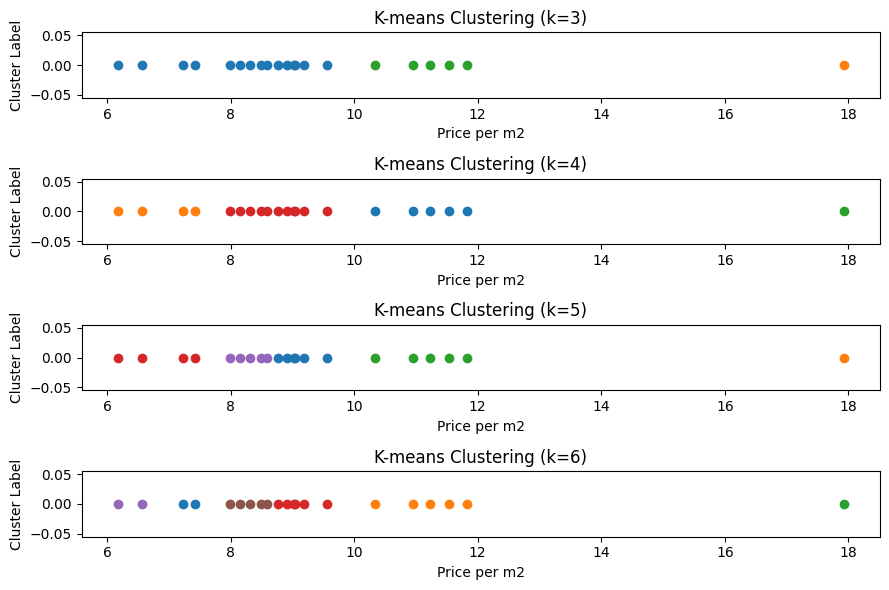

4


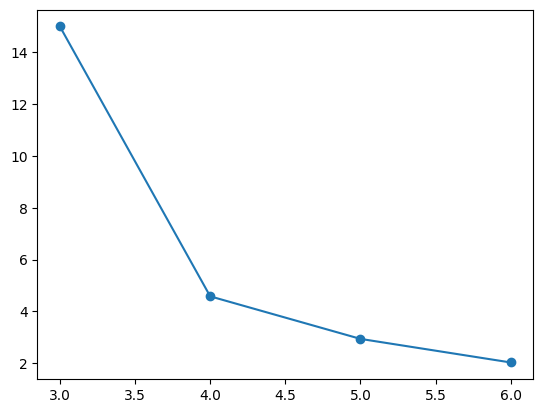

In [6]:
X = viv_zonas[['precio_m2']]

num_clusters_list = [3, 4, 5, 6]

fig, axes = plt.subplots(len(num_clusters_list), 1, figsize=(9, 6))
innertia_vals = []

for i, num_clusters in enumerate(num_clusters_list):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    innertia_vals.append(kmeans.inertia_)
    
    # Plot the clusters on the corresponding subplot
    ax = axes[i]
    for cluster_id in range(num_clusters):
        cluster_points = X[cluster_labels == cluster_id]
        ax.scatter(cluster_points, np.zeros(len(cluster_points)), label=f'Cluster {cluster_id}', cmap='rainbow')
    
    ax.set_xlabel('Price per m2')
    ax.set_ylabel('Cluster Label')
    ax.set_title(f'K-means Clustering (k={num_clusters})')

plt.tight_layout()
plt.show()

plt.plot(num_clusters_list, innertia_vals, marker='o')

min_index = np.argmin(np.diff(innertia_vals))
index = num_clusters_list[0] + min_index + 1
print(index)

### K-means: Agrupamos las zonas, teniendo en cuenta el número de habitaciones y el tamaño, con el objetivo de que las dos zonas estén en igualdad de condiciones

In [66]:
viv_zonas['cluster'] = cluster_labels
viv_zonas.sort_values('cluster')

,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones,cluster
20,sada,25,749.200000,8.490993,102.320000,2.360000,0
6,ciudad vieja - centro,31,1113.580645,11.221387,102.161290,2.161290,0
9,ensanche - juan florez,128,1221.859375,10.989687,119.914062,2.812500,1
18,perillo,31,1343.709677,11.832662,116.838710,2.870968,1
16,os mallos,47,742.765957,8.785018,87.042553,2.851064,2
1,agra del orzan - ventorrillo,44,744.318182,8.915367,86.795455,2.886364,2
3,bergondo,8,1116.875000,6.175132,186.375000,4.000000,3
10,falperra-santa lucia,14,740.714286,10.334224,76.357143,2.285714,4
8,culleredo,11,613.636364,8.581929,74.090909,2.272727,4
13,mesoiro,4,697.500000,8.584087,81.500000,2.250000,4


C:\Users\ivan\AppData\Local\Temp\ipykernel_12788\3699791341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['n_habitaciones'] = X['n_habitaciones'].apply(lambda x: x/0.33)
C:\Users\ivan\AppData\Local\Temp\ipykernel_12788\3699791341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tamano'] = X['tamano'].apply(lambda x: x/10)
c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to '

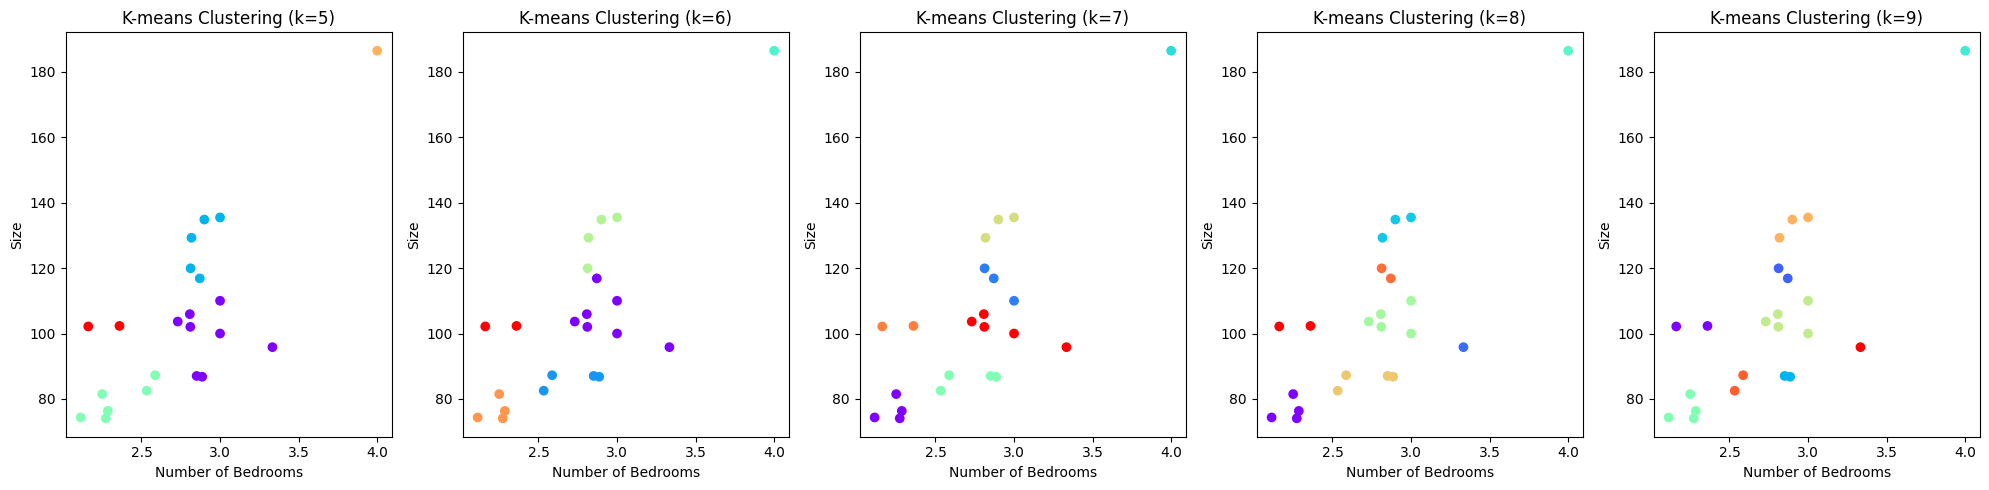

In [63]:
X = viv_zonas[['n_habitaciones', 'tamano']]
X['n_habitaciones'] = X['n_habitaciones'].apply(lambda x: x/0.33)
X['tamano'] = X['tamano'].apply(lambda x: x/10)

num_clusters_list = [5, 6, 7, 8, 9]

fig, axes = plt.subplots(1, len(num_clusters_list), figsize=(20, 5))

for i, num_clusters in enumerate(num_clusters_list):
    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=num_clusters)
    
    # Fit the model to the data
    kmeans.fit(X)
    
    # Get the cluster labels for each data point
    cluster_labels = kmeans.labels_
    
    # Add the cluster labels to the DataFrame
    plano['cluster'] = cluster_labels
    
    # Plot the clusters on the corresponding subplot
    axes[i].scatter(plano['n_habitaciones'], plano['tamano'], c=plano['cluster'], cmap='rainbow')
    axes[i].set_xlabel('Number of Bedrooms')
    axes[i].set_ylabel('Size')
    axes[i].set_title(f'K-means Clustering (k={num_clusters})')

plt.tight_layout()
plt.show()

Number of clusters found: 7


C:\Users\ivan\AppData\Local\Temp\ipykernel_12788\1800389091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['n_habitaciones'] = X['n_habitaciones'].apply(lambda x: x/0.5)
C:\Users\ivan\AppData\Local\Temp\ipykernel_12788\1800389091.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tamano'] = X['tamano'].apply(lambda x: x/10)


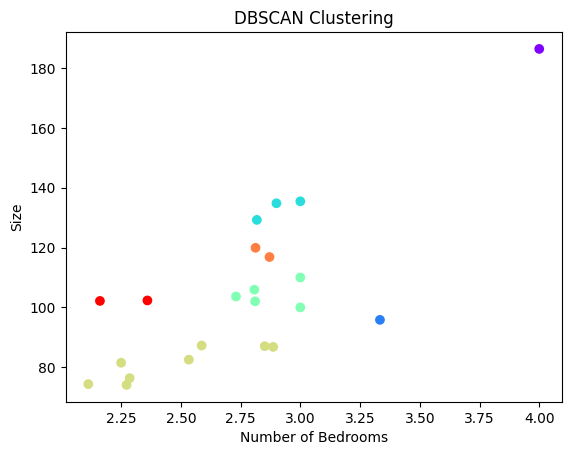

In [57]:
X = plano[['n_habitaciones', 'tamano']]

X['n_habitaciones'] = X['n_habitaciones'].apply(lambda x: x/0.5)
X['tamano'] = X['tamano'].apply(lambda x: x/10)

# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.7, min_samples=1)  # You need to adjust these parameters

# Fit the model to the scaled data
cluster_labels = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
plano['cluster'] = cluster_labels

print('Number of clusters found: {}'.format(len(plano['cluster'].unique())))

# Plot the clusters
plt.scatter(plano['n_habitaciones'], plano['tamano'], c=plano['cluster'], cmap='rainbow')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Size')
plt.title('DBSCAN Clustering')
plt.show()

Number of clusters found: 3


C:\Users\ivan\AppData\Local\Temp\ipykernel_12788\3866969395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['n_habitaciones'] = X['n_habitaciones'].apply(lambda x: x/0.5)
C:\Users\ivan\AppData\Local\Temp\ipykernel_12788\3866969395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tamano'] = X['tamano'].apply(lambda x: x/10)


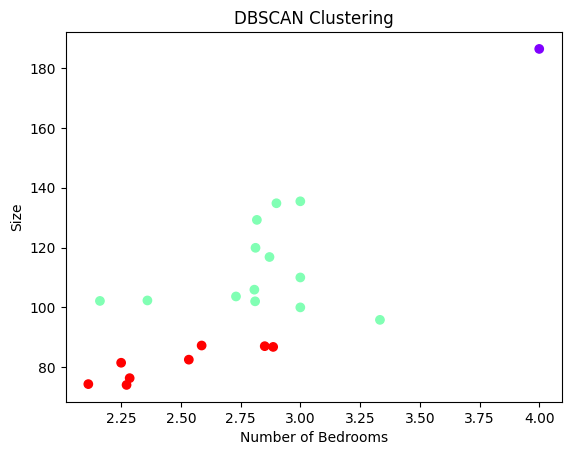

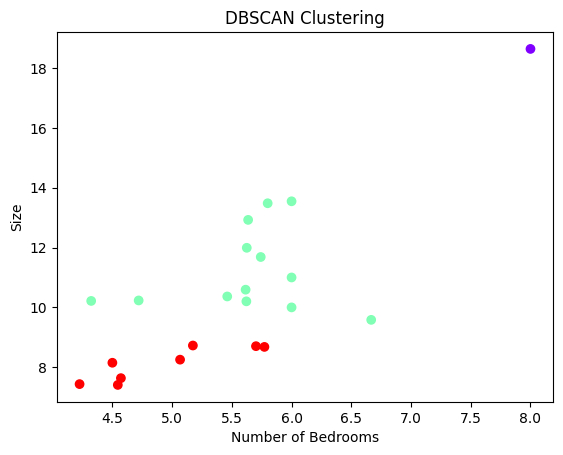

In [46]:
X = plano[['n_habitaciones', 'tamano']]
X['n_habitaciones'] = X['n_habitaciones'].apply(lambda x: x/0.5)
X['tamano'] = X['tamano'].apply(lambda x: x/10)

# Initialize the DBSCAN model
dbscan = DBSCAN(eps=1, min_samples=1)  # You need to adjust these parameters

# Fit the model to the scaled data
cluster_labels = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
plano['cluster'] = cluster_labels

print('Number of clusters found: {}'.format(len(plano['cluster'].unique())))

# Plot the clusters
plt.scatter(plano['n_habitaciones'], plano['tamano'], c=plano['cluster'], cmap='rainbow')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Size')
plt.title('DBSCAN Clustering')
plt.show()
plt.scatter(X['n_habitaciones'], X['tamano'], c=plano['cluster'], cmap='rainbow')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Size')
plt.title('DBSCAN Clustering')
plt.show()

### Otro método

In [5]:
tamanos = [20, 27, 35, 43, 50, 60, 70, 80, 90, 100, 110, 125, 140, 160, 200]
r_tamanos = [4, 4,  4,  4,  6,  6,  6,  6,  6,   6,   8,   8,  11,  25,  25]
n_habitaciones = [1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
min_viv_grupo = 6
zonas = []

for i in n_habitaciones:
    for j in tamanos:
        df = ds[(ds['n_habitaciones'] == i)]
        df = df[abs(df['tamano']-j)<r_tamanos[tamanos.index(j)]]
        if(len(df)>0):
            viv_zonas = df.groupby('zona_v2').agg({'titulo':'count','precio':'mean', 'precio_m2':'mean', 'tamano':'mean', 'n_habitaciones':'mean'}).reset_index()
            viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
            viv_zonas = viv_zonas[viv_zonas['n_viviendas']>=min_viv_grupo]
            viv_zonas = viv_zonas.sort_values(['precio'], ascending=False)
            if(len(viv_zonas)>1):
                for zona in viv_zonas['zona_v2'].values:
                    zonas.append(zona)
                display(viv_zonas)    
    
print(set(zonas))
print(len(set(zonas)))

,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
5,ensanche - juan florez,8,1256.25,21.235254,59.875,1.0
7,monte alto - zalaeta - atocha,8,751.25,12.615626,59.625,1.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
11,monte alto - zalaeta - atocha,11,741.363636,10.85375,68.363636,2.0
0,agra del orzan - ventorrillo,6,629.166667,9.10140,69.166667,2.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
4,ensanche - juan florez,6,916.666667,11.224377,81.833333,2.0
13,riazor - los rosales,7,792.857143,9.685002,82.000000,2.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
2,cuatro caminos - plaza de la cubela,7,1292.857143,14.890850,87.142857,2.0
3,ensanche - juan florez,8,853.750000,9.501684,90.125000,2.0
11,someso - matogrande,6,775.000000,8.774517,88.500000,2.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
8,monte alto - zalaeta - atocha,7,777.857143,9.460274,82.142857,3.0
4,cuatro caminos - plaza de la cubela,7,764.285714,9.343545,81.714286,3.0
10,os mallos,9,710.000000,8.552134,82.888889,3.0
0,agra del orzan - ventorrillo,11,630.000000,8.015118,78.727273,3.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
5,ensanche - juan florez,9,967.777778,10.642692,90.666667,3.0
10,monte alto - zalaeta - atocha,7,907.857143,10.251931,88.428571,3.0
4,cuatro caminos - plaza de la cubela,6,820.833333,9.384532,87.500000,3.0
12,os mallos,11,747.727273,8.488723,88.272727,3.0
0,agra del orzan - ventorrillo,7,728.571429,7.957786,91.285714,3.0
17,someso - matogrande,8,724.375000,8.148445,89.000000,3.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
4,ensanche - juan florez,7,927.142857,9.356157,99.571429,3.0
3,cuatro caminos - plaza de la cubela,10,912.500000,8.981874,101.600000,3.0
9,nos,8,765.000000,7.725624,99.000000,3.0
0,agra del orzan - ventorrillo,6,760.000000,7.735673,98.666667,3.0
13,riazor - los rosales,8,731.250000,7.316691,99.750000,3.0
1,arteixo,6,579.166667,5.811788,99.666667,3.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
7,ensanche - juan florez,13,1211.538462,10.997698,110.230769,3.0
5,cuatro caminos - plaza de la cubela,6,941.666667,8.689568,108.500000,3.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
4,ensanche - juan florez,7,1557.142857,11.239438,138.857143,3.0
3,cuatro caminos - plaza de la cubela,6,958.333333,6.862560,139.833333,3.0


,zona_v2,n_viviendas,precio,precio_m2,tamano,n_habitaciones
4,ensanche - juan florez,12,1656.666667,10.633683,155.583333,3.0
5,nos,6,1038.333333,7.039937,146.833333,3.0


{'agra del orzan - ventorrillo', 'someso - matogrande', 'os mallos', 'riazor - los rosales', 'arteixo', 'nos', 'ensanche - juan florez', 'cuatro caminos - plaza de la cubela', 'monte alto - zalaeta - atocha'}
9


In [6]:
def precio_medio_zona(x):
    '''
    Función que devuelve el precio por m2 medio de una zona de viviendas de tamaño y número de habitaciones similares
    '''
    min_items_grupo = 3
    id = x['id']
    hab = x['n_habitaciones']
    tam = x['tamano']
    zona_v2 = x['zona_v2']
    mun = x['municipio']
    r = 0.08*tam
    coor_x = x['direccion_x']
    coor_y = x['direccion_y']
    df = ds.copy()
    if hab <= 3:
        df = ds[(ds['n_habitaciones'] == hab)]
    elif hab == 4:
        df = ds[(ds['n_habitaciones'] ==3) | (ds['n_habitaciones'] ==4)]
    df = df[abs(df['tamano']-tam)<r]
    df = df[df['zona_v2'] == zona_v2]
    df = df[df['id'] != id]
    if len(df)>=min_items_grupo:
        df['precio_m2'] = df['precio']/df['tamano']
        return np.mean(df['precio_m2'])
    else:
        df = ds.copy()
        df = df[df['municipio'] == mun]
        if hab <= 3:
            df = df[(df['n_habitaciones'] == hab)]
        elif hab == 4:
            df = df[(df['n_habitaciones'] ==3) | (df['n_habitaciones'] ==4)]
        df = df[df['id'] != id]
        if len(df) >= min_items_grupo:
            df['precio_m2'] = df['precio']/df['tamano']
            return np.mean(df['precio_m2'])
        else: 
            df = ds.copy()
            df = df[df['municipio'] == mun]
            df = df[df['id'] != id]
            if(len(df)>=min_items_grupo):
                df['precio_m2'] = df['precio']/df['tamano']
                return np.mean(df['precio_m2'])
            else:
                df = ds[['precio', 'tamano', 'direccion_x', 'direccion_y', 'id']].copy()
                df = df[df['id']!=id]
                df['dist'] = df.apply(lambda x : get_distance(x['direccion_x'], x['direccion_y'], coor_x, coor_y), axis=1)
                df = df.sort_values('dist', ascending=True)
                df = df.head(7)
                df['precio_m2'] = df['precio']/df['tamano']
                return np.mean(df['precio_m2'])

In [7]:
def get_distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [8]:
sum(~pd.isna(ds.apply(func, axis=1)))

724

In [9]:
ds.apply(func, axis=1)

0       7.838463
1       9.553217
2      10.071854
3      10.053937
4       8.531092
         ...    
719     6.750000
720     8.422889
721     9.487179
722     8.692956
723    14.377873
Length: 724, dtype: float64